# Deep Sets

Goal: pip install his package, and see if you can run his PFN example.

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False



Using TensorFlow backend.


In [2]:
################################### SETTINGS ###################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 75000, 10000, 15000
use_pids = True

# network architecture parameters
ppm_sizes = (100, 100, 128)
dense_sizes = (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

################################################################################


In [3]:
# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')


Loaded quark and gluon jets
Finished preprocessing


In [4]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], ppm_sizes=ppm_sizes, dense_sizes=dense_sizes)


Done train/val/test split
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 4)           0         
_________________________________________________________________
mask_0 (Masking)             (None, None, 4)           0         
_________________________________________________________________
tdist_0 (TimeDistributed)    (None, None, 100)         500       
_________________________________________________________________
tdist_1 (TimeDistributed)    (None, None, 100)         10100     
_________________________________________________________________
tdist_2 (TimeDistributed)    (None, None, 128)         12928     
_________________________________________________________________
sum (Lambda)                 (None, 128)               0         
_________________________________________________________________
dense_0 (Dense)              (None,

In [5]:
# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

Train on 75000 samples, validate on 10000 samples
Epoch 1/5
75000/75000 [==============================] - 37s 488us/step - loss: 0.5904 - acc: 0.7396 - val_loss: 0.4803 - val_acc: 0.7756
Epoch 2/5
75000/75000 [==============================] - 35s 469us/step - loss: 0.4729 - acc: 0.7817 - val_loss: 0.4761 - val_acc: 0.7809
Epoch 3/5
75000/75000 [==============================] - 35s 469us/step - loss: 0.4656 - acc: 0.7871 - val_loss: 0.4571 - val_acc: 0.7881
Epoch 4/5
75000/75000 [==============================] - 35s 467us/step - loss: 0.4599 - acc: 0.7896 - val_loss: 0.4675 - val_acc: 0.7856
Epoch 5/5
75000/75000 [==============================] - 35s 467us/step - loss: 0.4577 - acc: 0.7912 - val_loss: 0.4597 - val_acc: 0.7941



PFN AUC: 0.8700589937620263



/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


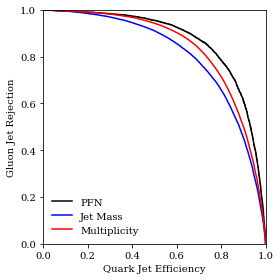

In [6]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('PFN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()

Wow, it's working out of the box! (I wasn't expecting this... cool!)

## Testing for b-tagging

Ok, so since this was so painless to run, maybe I should just try training a basic model for b-tagging w/ the same hyperparameters (the only thing is I'll try to change the # of hyperparameters that I'm looking for.)

My goal rn is just to make sure the architecture works and I can train, because I think for a full comparison and production, I'm going to want to merge this w/ my framework.

**Step 1:** Load in the training data

In [10]:
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

subDir = 'mc16d_Topo_ttbar'
dataDir = '../../data/'+subDir
dataTag = "3mtrain_15trks_{}_sd0_rev".format(vStr)

In [8]:
import h5py

In [12]:
f_name = "{}/data_{}.hdf5".format(dataDir,dataTag)

f = h5py.File(f_name,"r")

X_train = f['X_train'][:]
y_train = f['y_train'][:]
ix_train = f['ix_train'][:]

f.close()

**Step 2:** Initialize in the model

In [13]:
ppm_sizes

(100, 100, 128)

In [14]:
dense_sizes

(100, 100, 100)

In [17]:
?EFN

Object `EFN` not found.


In [24]:
pfn = PFN(input_dim=X_train.shape[-1], ppm_sizes=ppm_sizes, dense_sizes=dense_sizes, 
          output_dim=4, latent_dropout=0.25) #, dense_dropouts=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 13)          0         
_________________________________________________________________
mask_0 (Masking)             (None, None, 13)          0         
_________________________________________________________________
tdist_0 (TimeDistributed)    (None, None, 100)         1400      
_________________________________________________________________
tdist_1 (TimeDistributed)    (None, None, 100)         10100     
_________________________________________________________________
tdist_2 (TimeDistributed)    (None, None, 128)         12928     
_________________________________________________________________
sum (Lambda)                 (None, 128)               0         
_________________________________________________________________
latent_dropout (Dropout)     (None, 128)               0         
__________

**Note:** Right out of the bat, he has *a lot* more trainable parameters than we do! (like 60k c.f. 13k)

In [25]:
pfn.fit(X_train, to_categorical(y_train.astype(int)),
        epochs=num_epoch,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1)

Train on 2400000 samples, validate on 600000 samples
Epoch 1/5
2400000/2400000 [==============================] - 209s 87us/step - loss: 0.6019 - acc: 0.7952 - val_loss: 0.5649 - val_acc: 0.8043
Epoch 2/5
2400000/2400000 [==============================] - 206s 86us/step - loss: 0.5682 - acc: 0.8036 - val_loss: 0.5556 - val_acc: 0.8075
Epoch 3/5
2400000/2400000 [==============================] - 207s 86us/step - loss: 0.5610 - acc: 0.8060 - val_loss: 0.5548 - val_acc: 0.8085
Epoch 4/5
2400000/2400000 [==============================] - 205s 86us/step - loss: 0.5566 - acc: 0.8075 - val_loss: 0.5513 - val_acc: 0.8095
Epoch 5/5
2400000/2400000 [==============================] - 205s 86us/step - loss: 0.5539 - acc: 0.8083 - val_loss: 0.5588 - val_acc: 0.8066


In [26]:
pfn.latent_layer

<tf.Tensor 'latent_dropout_6/cond/Merge:0' shape=(?, 128) dtype=float32>

**Outstanding questions:**
- Can I add in the sample weights?

**Step 3:** Get the test data

In [27]:
dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

f = h5py.File(f_name,"r")

X_test = f['X_test'][:]
y_test = f['y_test'][:]
ix_test = f['ix_test'][:]

f.close()

In [28]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

**Step 4:** Look at some metrics

In [29]:
fc = 0.07

disc = np.log(np.divide(preds[:,2], fc*preds[:,1] + (1 - fc) * preds[:,0]))

discMax = np.max(disc)
discMin = np.min(disc)

myRange=(discMin,discMax)
nBins = 200

In [31]:
import sys
sys.path.append("../..")
from plottingFcts import *

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


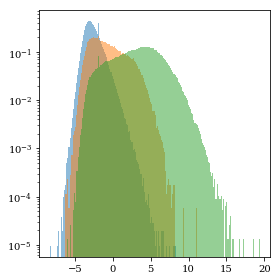

In [32]:
effs = []

for output, flavor in zip([0,1,2], ['l','c','b']):

    ix = (y_test == output)

    # Plot the discriminant output
    nEntries, edges ,_ = plt.hist(disc[ix],alpha=0.5,label='{}-jets'.format(flavor),
                                  bins=nBins, range=myRange, density=True, log=True)

    # Calculate the baseline signal and bkg efficiencies
    eff = calculateEff(nEntries)
    effs.append(eff)

In [33]:
leffs, ceffs, beffs = effs

../../plottingFcts.py:456: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


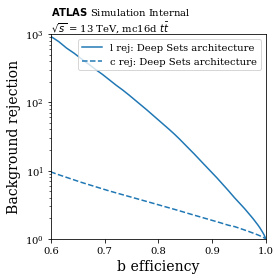

In [34]:
btagROC([beffs], [leffs], [ceffs], ['Deep Sets architecture'])

**Good news!** Th l-rej is 900 @ the 60% WP.